In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [140]:
# Paths to the data files
abundance_file_path = './data/species_abundance_filt.csv'
organism_subset_file_path = './data/organism_data_to_subset.csv'

# Load both files
# species_abundance_filt.csv: This file contains abundance data for different species, 
# used to filter and visualize abundance patterns based on environmental variables such as soil pH.
# The column "taxon" in this file corresponds to "Species of interest" in organism_data_to_subset.csv,
# allowing the two datasets to be merged for visualization.
df_abundance = pd.read_csv(abundance_file_path)

# organism_data_to_subset.csv: This file contains information on environmental preferences for various species,
# such as soil pH preference. The column "Species of interest" in this file aligns with "taxon" in
# species_abundance_filt.csv, enabling filtering and visualization based on specific environmental preferences.
df_to_subset = pd.read_csv(organism_subset_file_path)



# Check Data Sizes

In [141]:
print(df_abundance.shape)
print(df_to_subset.shape)
unique_species_count = df_to_subset['Species of interest'].nunique()
print(unique_species_count)

(66210, 24)
(31815, 22)
18589


Duplicates in subset of organisms, need to remove

In [142]:
# Check for duplicates in the 'Species of interest' column
duplicates = df_to_subset[df_to_subset.duplicated(subset='Species of interest', keep=False)]
duplicate_species_names = duplicates['Species of interest'].unique()

# Print the names of duplicate species
print(duplicate_species_names)

['Shewanella putrefaciens' 'Myxococcus fulvus' 'Myxococcus xanthus' ...
 'Streptomyces sp. B3I8' 'Streptomyces sp. V2I9'
 'Streptomyces vilmorinianum']


# Remove Duplicates

In [143]:
# Remove Duplicate Species
df_to_subset = df_to_subset.drop_duplicates(subset='Species of interest')
df_to_subset.shape

(18589, 22)

# Merge Data

In [144]:
merged_data = pd.merge(
    df_to_subset, df_abundance, 
    left_on='Species of interest', right_on='name', 
    how='inner'
)


merged_data.shape


(66210, 46)

In [145]:
print(merged_data.columns)
top_species = merged_data.groupby('Species of interest').size().nlargest(10).reset_index(name='count')
top_species


Index(['Unnamed: 0', 'taxonomy_id_x', 'temperature_preference',
       'pH_preference', 'Species of interest', 'taxon_x', 'cultivatedCrops',
       'deciduousForest', 'dwarfScrub', 'emergentHerbaceousWetlands',
       'evergreenForest', 'grasslandHerbaceous', 'mixedForest', 'pastureHay',
       'sedgeHerbaceous', 'shrubScrub', 'woodyWetlands',
       'Metagenome-assembled genome?', 'GEM match criteria', 'GEM_ID',
       'Genome source', 'accession', 'name', 'taxonomy_id_y', 'percentage',
       'lineage', 'source', 'is_MAG', 'taxid_lineage', 'genomicsSampleID',
       'd15N', 'organicd13C', 'nitrogenPercent', 'organicCPercent', 'soilTemp',
       'soilMoisture', 'soilInWaterpH', 'soilInCaClpH', 'latitude',
       'longitude', 'elevation', 'sampleTiming', 'nlcdClass', 'db_name',
       'taxon_y', 'n_samples'],
      dtype='object')


,Species of interest,count
0,Deltaproteobacteria bacterium,1357
1,Verrucomicrobiaceae bacterium,1355
2,Hyphomicrobiaceae bacterium,1345
3,Methylobacterium oryzihabitans,1326
4,Nonomuraea sp. NEAU-A123,1321
5,Mycobacterium sp. 1245111.1,1310
6,uncultured Telmatospirillum sp.,1308
7,Bordetella genomosp. 9,1303
8,Chloroflexi bacterium OHK40,1302
9,Ramlibacter ginsenosidimutans,1300


# Save merged data

In [146]:
merged_data.to_csv('./data/merged_data.csv', index=False)

# Check distribution of entries per species

/var/folders/r7/lxsjn34n3ps34t_1wj1z84680000gn/T/ipykernel_13140/2474854307.py:4: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv('data/merged_data.csv')


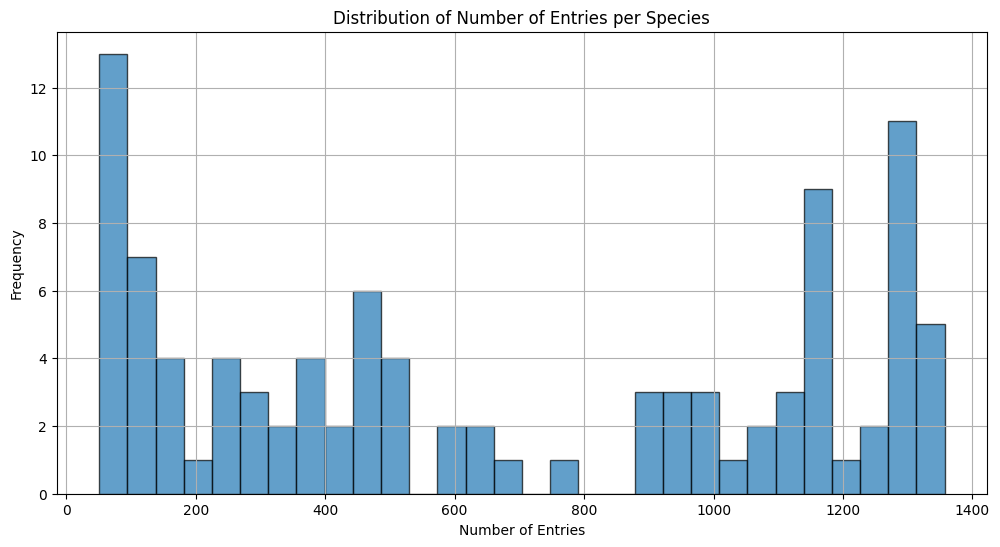

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
# Group by "Species of interest" and count the number of entries
merged_data = pd.read_csv('data/merged_data.csv')
species_counts = merged_data.groupby('Species of interest').size().reset_index(name='count')

# Plot the distribution of the number of entries
plt.figure(figsize=(12, 6))
plt.hist(species_counts['count'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Entries')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Entries per Species')
plt.grid(True)
plt.show()


# Modeling (XGboost with RandomSeach)


/var/folders/r7/lxsjn34n3ps34t_1wj1z84680000gn/T/ipykernel_13140/2855567001.py:12: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv("data/merged_data.csv")


Initial Shape: (66210, 46))
Shape of after removal: (50130, 46))
Handling missing values by filling with mean...
Splitting data into train and test sets...
Shape of X_train: (35091, 14), Shape of y_train: (35091,)
Shape of X_test: (15039, 14), Shape of y_test: (15039,)
Standardizing features...
Starting Randomized Search for XGBoost...

Best Hyperparameters for XGBoost: {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.1711111111111111, 'gamma': 1, 'colsample_bytree': 0.6}
Best R² Score from Cross-Validation: 0.61
Evaluating the optimized XGBoost model on the test set...
Test R²: 0.63
Mean Squared Error: 0.59
Visualizing predictions vs. true values...


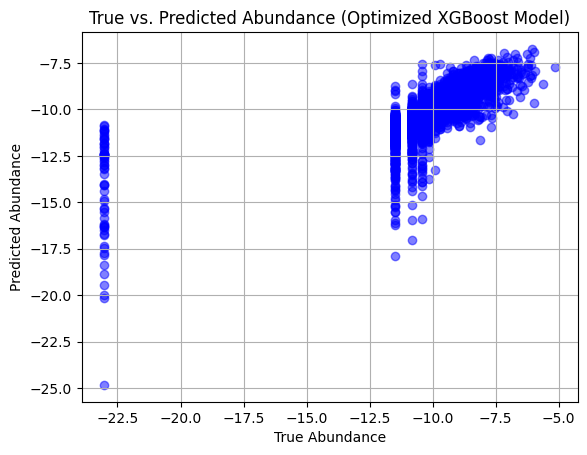

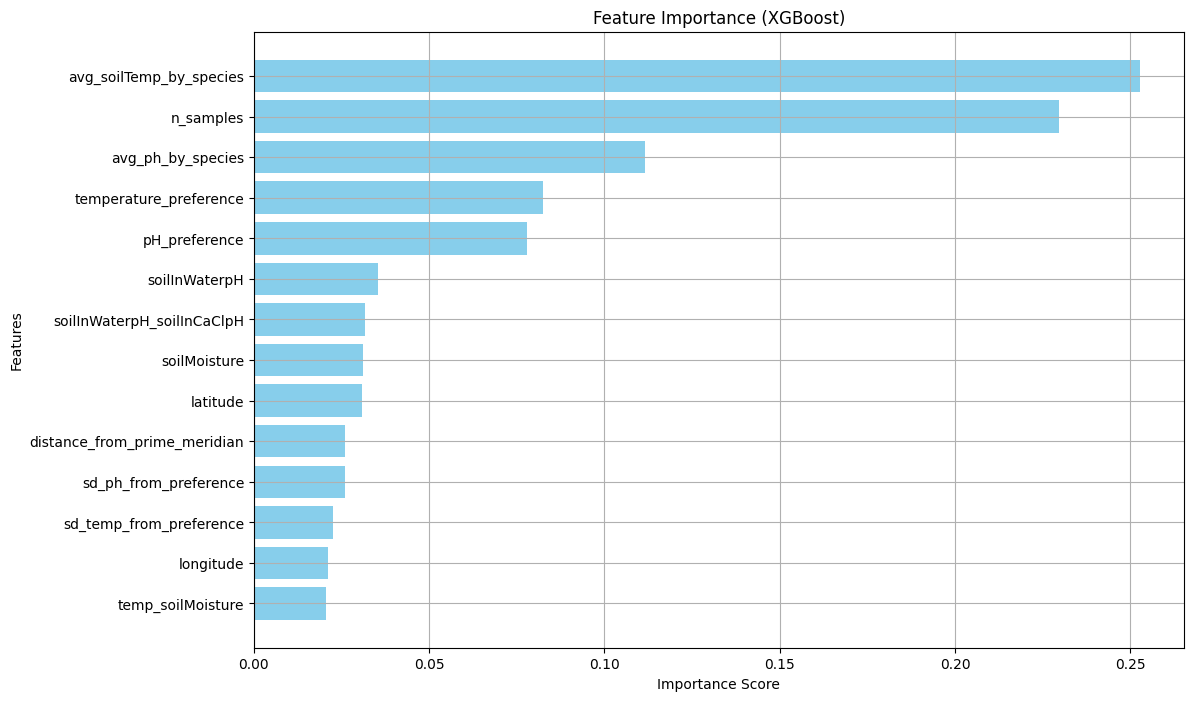

Predicting abundance percentage for all entries...
Predictions saved to predicted_abundance.csv


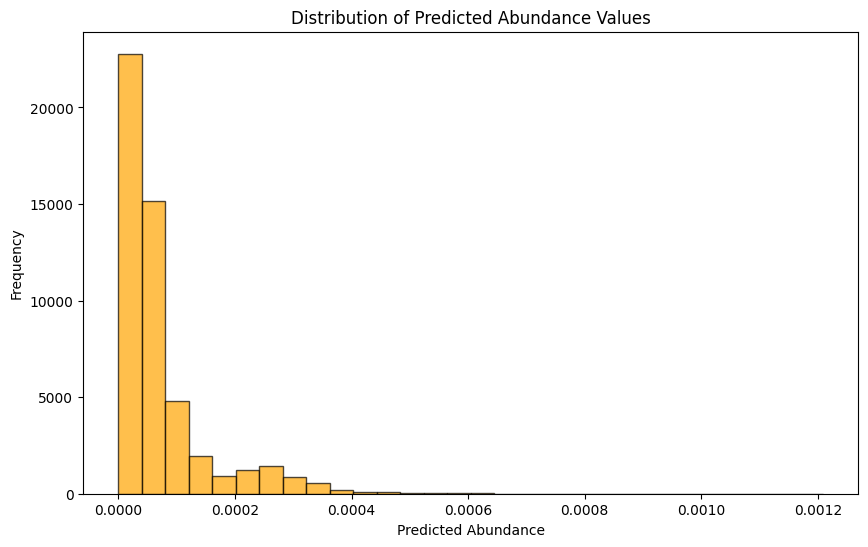

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Load dataset
merged_data = pd.read_csv("data/merged_data.csv")

print(f"Initial Shape: {merged_data.shape})")

# Filter out species with less than 800 entries
species_counts = merged_data['Species of interest'].value_counts()
species_to_keep = species_counts[species_counts >= 800].index
merged_data = merged_data[merged_data['Species of interest'].isin(species_to_keep)]
print(f"Shape of after removal: {merged_data.shape})")

# Feature Engineering
merged_data['temp_soilMoisture'] = merged_data['temperature_preference'] * merged_data['soilMoisture']
merged_data['soilInWaterpH_soilInCaClpH'] = merged_data['soilInWaterpH'] * merged_data['soilInCaClpH']
merged_data['temperature_preference_squared'] = merged_data['temperature_preference'] ** 2
merged_data['pH_preference_squared'] = merged_data['pH_preference'] ** 2
merged_data['soilMoisture_squared'] = merged_data['soilMoisture'] ** 2
merged_data['distance_from_equator'] = np.abs(merged_data['latitude'])
merged_data['distance_from_prime_meridian'] = np.abs(merged_data['longitude'])

species_avg_temp = merged_data.groupby('Species of interest')['soilTemp'].mean()
merged_data['avg_soilTemp_by_species'] = merged_data['Species of interest'].map(species_avg_temp)

species_avg_ph = merged_data.groupby('Species of interest')['soilInWaterpH'].mean()
merged_data['avg_ph_by_species'] = merged_data['Species of interest'].map(species_avg_ph)

# Calculate SD for soil pH (relative to pH preference)
merged_data['sd_ph_from_preference'] = (merged_data['soilInWaterpH'] - merged_data['pH_preference']) ** 2

# Calculate SD for soil temperature (relative to temperature preference)
merged_data['sd_temp_from_preference'] = (merged_data['soilTemp'] - merged_data['temperature_preference']) ** 2

# Take the square root to compute the standard deviation
merged_data['sd_ph_from_preference'] = np.sqrt(merged_data['sd_ph_from_preference'])
merged_data['sd_temp_from_preference'] = np.sqrt(merged_data['sd_temp_from_preference'])


required_columns = [
    'temperature_preference', 'pH_preference', 'soilMoisture',
    'soilInWaterpH', 'latitude', 'longitude', 
    'temp_soilMoisture', 'soilInWaterpH_soilInCaClpH',
     'distance_from_prime_meridian',
    'n_samples',
    'avg_soilTemp_by_species', 'avg_ph_by_species', 'sd_ph_from_preference', 'sd_temp_from_preference'
]

# Check if all required columns exist in the DataFrame
missing_columns = [col for col in required_columns if col not in merged_data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

features = merged_data[required_columns].copy()
target = merged_data['percentage']

# Handle missing values
print("Handling missing values by filling with mean...")
features = features.fillna(features.mean())
target = target.fillna(target.mean())
target = np.log(target + 1e-10)  # Apply log transformation to the target

# Train-test split
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Set up the parameter distribution for random search
param_distributions = {
    'n_estimators': np.arange(50, 300, 50),  # Number of trees
    'max_depth': np.arange(3, 10),           # Maximum tree depth
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Learning rate
    'subsample': np.linspace(0.6, 1.0, 5),       # Subsample ratio
    'colsample_bytree': np.linspace(0.6, 1.0, 5), # Fraction of features sampled
    'gamma': np.arange(0, 5, 1)                  # Minimum loss reduction for split
}

# Set up the RandomizedSearchCV
print("Starting Randomized Search for XGBoost...")
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random parameter combinations to try
    scoring='r2',  # Use R² score for evaluation
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=0,  # Verbosity mode
    random_state=42
)

# Perform the random search
random_search.fit(X_train_scaled, y_train)

# Retrieve the best model and parameters
best_xgb_model = random_search.best_estimator_
best_params = random_search.best_params_
best_r2_cv = random_search.best_score_

print("\nBest Hyperparameters for XGBoost:", best_params)
print(f"Best R² Score from Cross-Validation: {best_r2_cv:.2f}")

# Evaluate the optimized model on the test set
print("Evaluating the optimized XGBoost model on the test set...")
y_pred_optimized = best_xgb_model.predict(X_test_scaled)
optimized_r2 = r2_score(y_test, y_pred_optimized)
optimized_mse = mean_squared_error(y_test, y_pred_optimized)

print(f"Test R²: {optimized_r2:.2f}")
print(f"Mean Squared Error: {optimized_mse:.2f}")

# Visualize predictions vs. true values
print("Visualizing predictions vs. true values...")
plt.scatter(y_test, y_pred_optimized, alpha=0.5, color="blue")
plt.xlabel("True Abundance")
plt.ylabel("Predicted Abundance")
plt.title("True vs. Predicted Abundance (Optimized XGBoost Model)")
plt.grid(True)
plt.show()

# Plot feature importance
feature_importances = best_xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort features by importance

plt.figure(figsize=(12, 8))
plt.barh(np.array(features.columns)[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (XGBoost)")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.grid(True)
plt.show()


# Use the optimized model to predict abundance percentages for all entries
print("Predicting abundance percentage for all entries...")

# Ensure features are scaled properly
features_scaled = scaler.transform(features)

# Make predictions using the optimized model
predictions_scaled = best_xgb_model.predict(features_scaled)

# Inverse the log transformation to get the original scale
predictions_original_scale = np.exp(predictions_scaled) - 1e-10

# Add the predictions back to the original DataFrame
merged_data['predicted_percentage'] = predictions_original_scale

# Select only the 'Species of interest' and 'predicted_percentage' columns for saving
predicted_abundance = merged_data[['Species of interest', 'predicted_percentage', 'pH_preference', 'percentage', 'soilInCaClpH']]

# Save the results to a new CSV file
output_file = "predicted_abundance.csv"
predicted_abundance.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")

# Visualize the distribution of predicted values
plt.figure(figsize=(10, 6))
plt.hist(predictions_original_scale, bins=30, edgecolor='k', alpha=0.7, color="orange")
plt.xlabel('Predicted Abundance')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Abundance Values')
plt.show()


/var/folders/r7/lxsjn34n3ps34t_1wj1z84680000gn/T/ipykernel_13140/2677383351.py:8: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv("data/merged_data.csv")


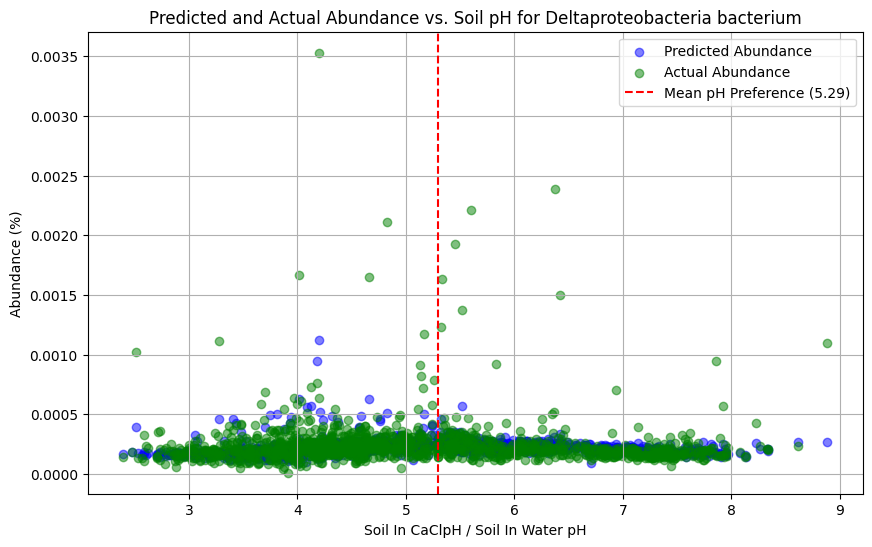

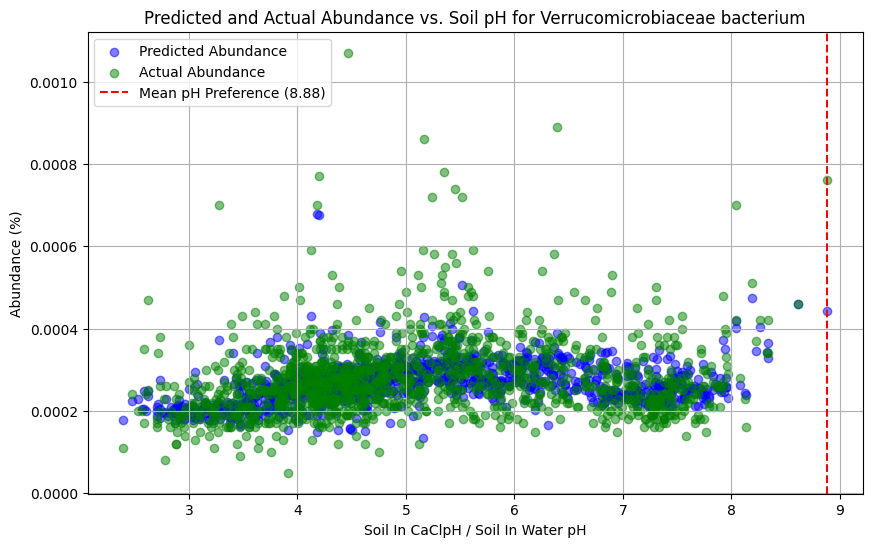

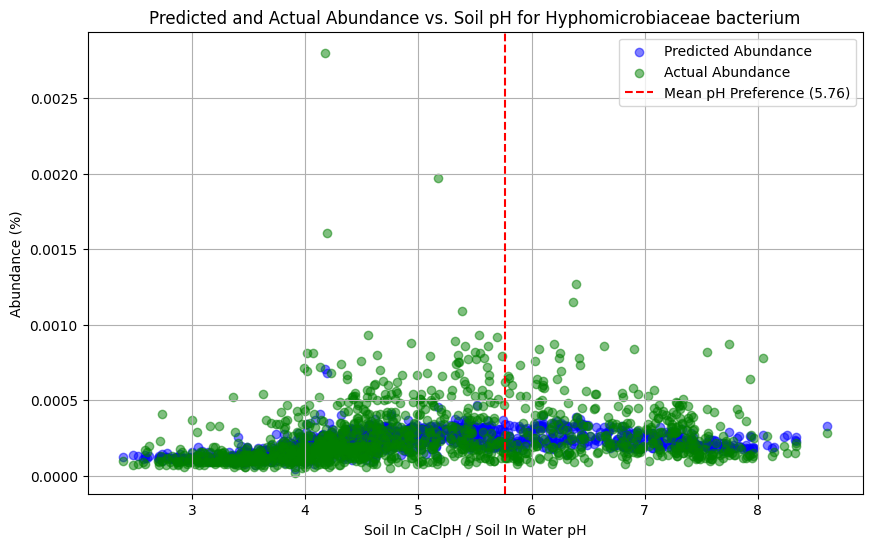

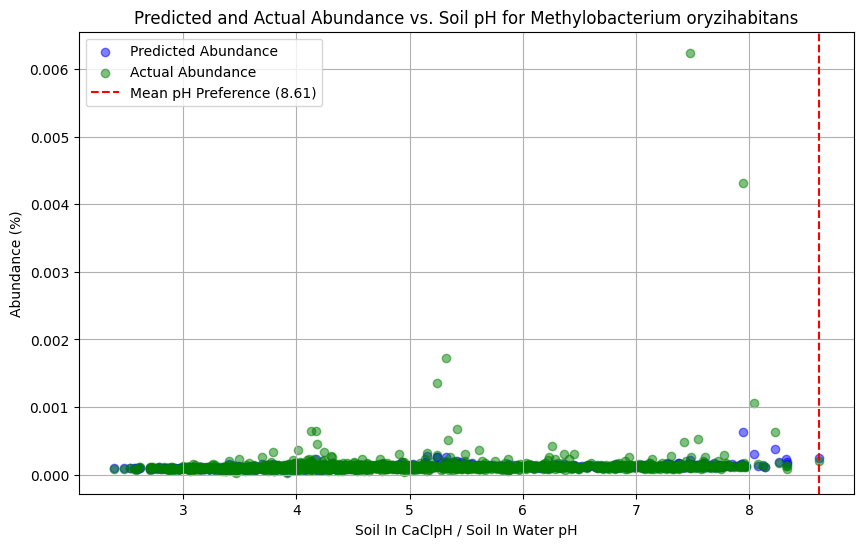

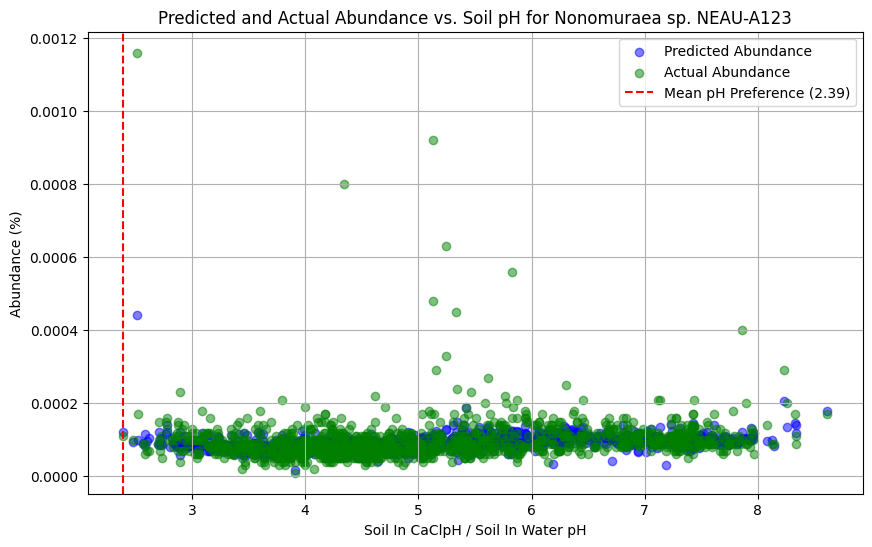

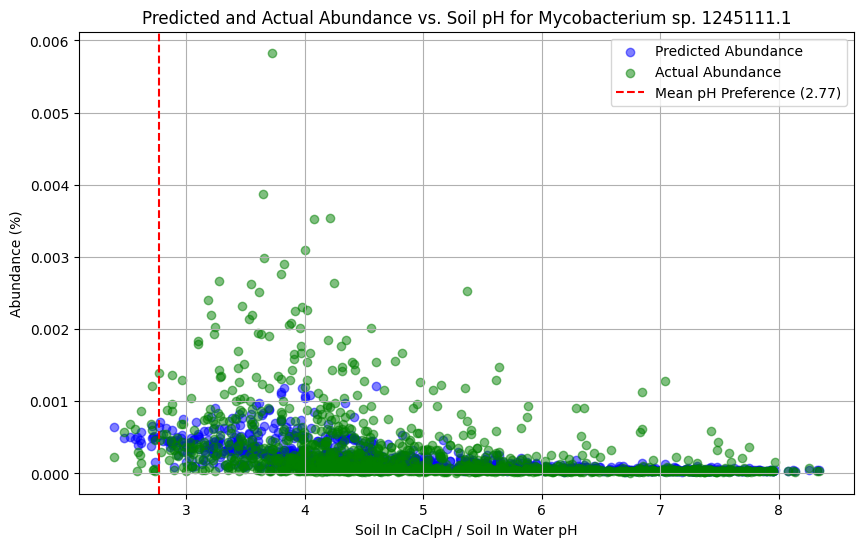

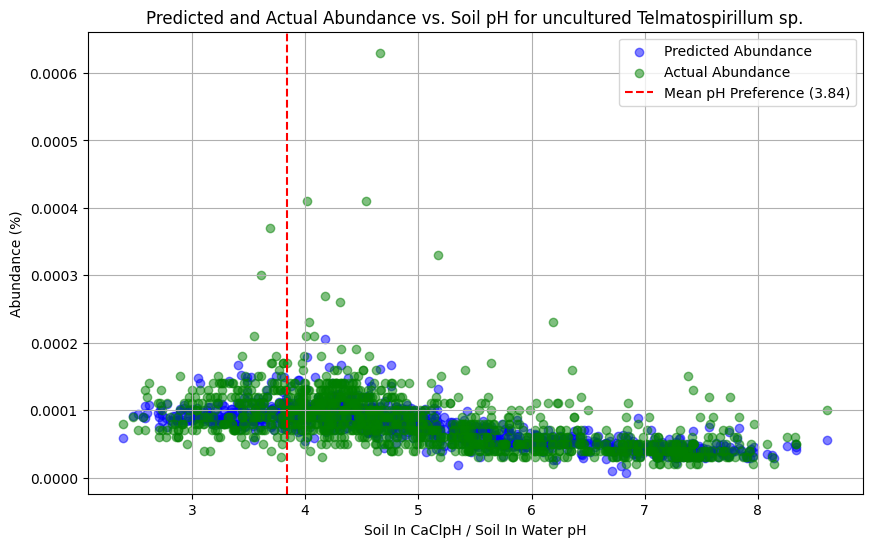

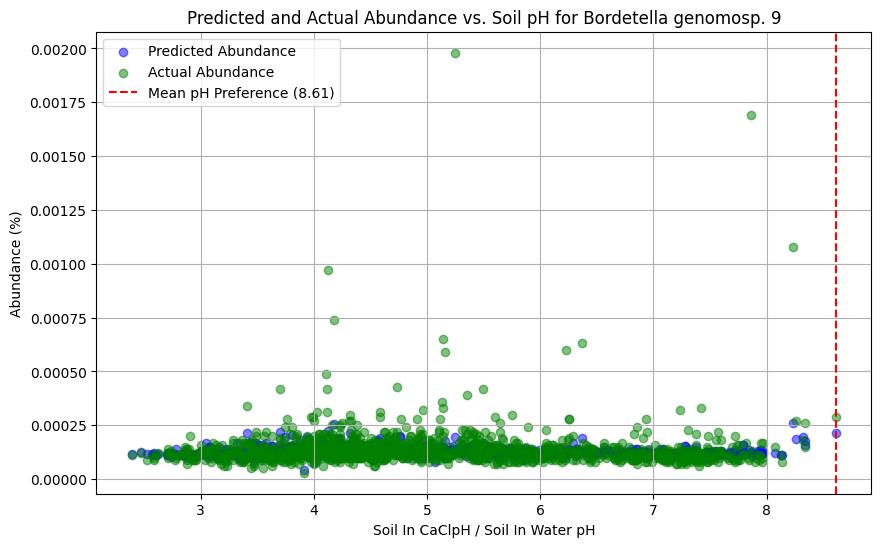

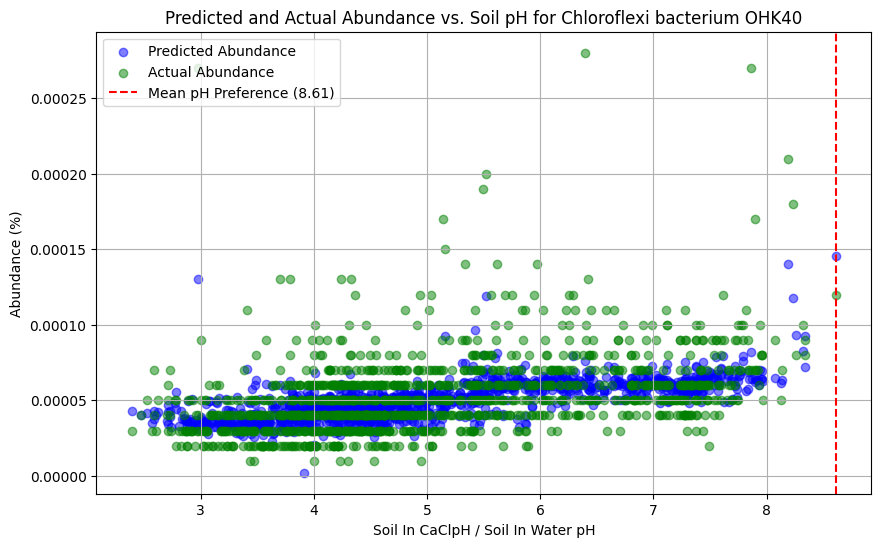

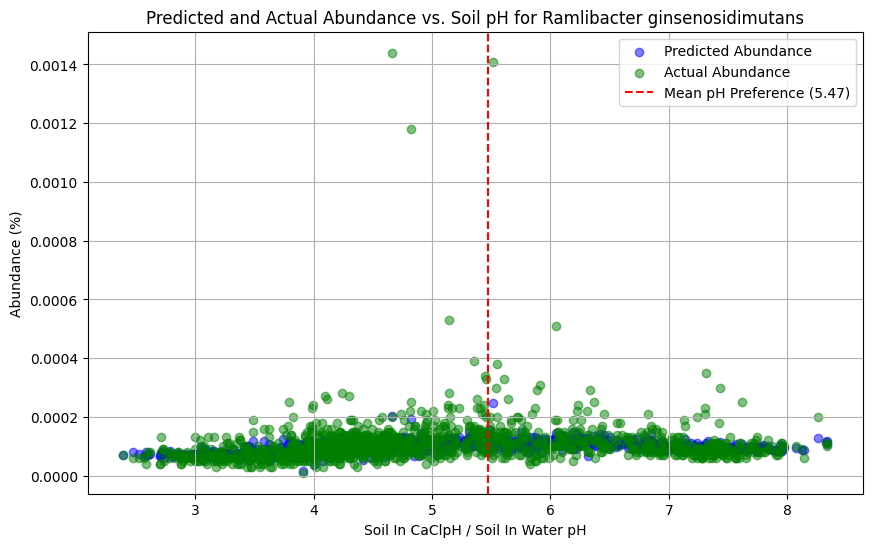

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the predicted abundance data
predicted_abundance_df = pd.read_csv('predicted_abundance.csv')

# Load the actual merged data (this should have the actual abundance values)
merged_data = pd.read_csv("data/merged_data.csv")

# List of species you want to plot
species_list = [
    'Deltaproteobacteria bacterium',
    'Verrucomicrobiaceae bacterium',
    'Hyphomicrobiaceae bacterium',
    'Methylobacterium oryzihabitans',
    'Nonomuraea sp. NEAU-A123',
    'Mycobacterium sp. 1245111.1',
    'uncultured Telmatospirillum sp.',
    'Bordetella genomosp. 9',
    'Chloroflexi bacterium OHK40',
    'Ramlibacter ginsenosidimutans'
]

# Loop through each species in the list
for species_name in species_list:
    # Filter the data for the current species
    species_data_pred = predicted_abundance_df[predicted_abundance_df['Species of interest'] == species_name]
    species_data_actual = merged_data[merged_data['Species of interest'] == species_name]

    # Get the mean pH preference
    mean_ph_preference = species_data_pred['pH_preference'].mean()

    # Create the scatter plot
    plt.figure(figsize=(10, 6))

    # Plot predicted abundance
    plt.scatter(species_data_pred['soilInCaClpH'], species_data_pred['predicted_percentage'], alpha=0.5, label='Predicted Abundance', color='blue')

    # Plot actual abundance
    plt.scatter(species_data_actual['soilInCaClpH'], species_data_actual['percentage'], alpha=0.5, label='Actual Abundance', color='green')

    # Plot the mean pH preference line
    plt.axvline(x=mean_ph_preference, color='r', linestyle='--', linewidth=1.5, label=f'Mean pH Preference ({mean_ph_preference:.2f})')

    # Add labels, title, and legend
    plt.legend()
    plt.xlabel('Soil In CaClpH / Soil In Water pH')
    plt.ylabel('Abundance (%)')
    plt.title(f'Predicted and Actual Abundance vs. Soil pH for {species_name}')
    plt.grid(True)

    # Show the plot for the current species
    plt.show()
